In [22]:
import pandas as pd
import os
from glob import glob
import json
from sklearn.metrics import classification_report

from seqeval.metrics import accuracy_score
from seqeval.metrics import classification_report as seq_report
from seqeval.metrics import f1_score

from matplotlib import pyplot as plt

In [2]:
all_model = ['bert-base-cased',
 'bert-base-uncased',
 'bert-large-cased',
 'bert-large-uncased',
 'albert-base-v2',
 'albert-large-v2',
 'albert-xlarge-v2',
 'albert-xxlarge-v2',
 'microsoft/deberta-v3-base',
 'microsoft/deberta-v3-large',
 'roberta-base',
 'roberta-large']

# Table 1. Generic comparison of ppl, cls, ner


In [26]:
result = {}

# TABLE 1. Read model ppl, F1 CLS, F1 NER
for model in all_model:
    base_ppl = json.load(open(f"../output/{model}/all_results.json"))["perplexity"]
    base_cls_f1 = json.load(open(f"../output/classifier/{model}/all_results.json"))["eval_f1"]
    base_ner_f1 = json.load(open(f"../output/ner/{model}/all_results.json"))["eval_overall_f1"]
    aeroBERT_ppl = json.load(open(f"../output/aeroBERTv2-{model}/all_results.json"))["perplexity"]
    aeroBERT_cls_f1 = json.load(open(f"../output/classifier/aeroBERTv2-{model}/all_results.json"))["eval_f1"]
    aeroBERT_ner_f1 = json.load(open(f"../output/ner/aeroBERTv2-{model}/all_results.json"))["eval_overall_f1"]
    result[model] = {"ppl": {"base": base_ppl, "aeroBERTv2": aeroBERT_ppl},
                    "cls_f1": {"base": base_cls_f1, "aeroBERTv2": aeroBERT_cls_f1},
                    "ner_f1": {"base": base_ner_f1, "aeroBERTv2": aeroBERT_ner_f1}}

In [27]:
# Preparing data for DataFrame
rows = []
for model, sub_models in result.items():
    row = [model]
    for sub_model, metrics in sub_models.items():
        row.extend(metrics.values())
    rows.append(row)

# Define MultiIndex for columns
columns = pd.MultiIndex.from_tuples([
    ('', 'Model name'),
    ('PPL', 'Base model'),
    ('PPL', 'aeroBERTv2'),
    ('CLS F1', 'Base model'),
    ('CLS F1', 'aeroBERTv2'),
    ('NER F1', 'Base model'),
    ('NER F1', 'aeroBERTv2')
])

# Create DataFrame
df = pd.DataFrame(rows, columns=columns)

In [28]:
df.to_latex("../notebooks/compare_aeroBERTv2.tex", index=False, escape=False, float_format="%.2f")

/tmp/ipykernel_961705/172814051.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex("../notebooks/compare_aeroBERTv2.tex", index=False, escape=False, float_format="%.2f")


# Table 2. Comparison of CLS metrics


In [3]:
test_gt = pd.read_json("../data/classifier/test.json",lines=True)["label"].to_list()

result_cls = {}
for model in all_model:
    test_pred = pd.read_csv(f"../output/classifier/{model}/predict_results.txt", sep="\t")["prediction"].to_list()
    cls_report = classification_report(test_gt, test_pred, output_dict=True, zero_division=0)
    result_cls[model] = [
        cls_report['Design']["precision"],
        cls_report['Design']["recall"],
        cls_report['Design']["f1-score"],
        cls_report['Functional']["precision"],
        cls_report['Functional']["recall"],
        cls_report['Functional']["f1-score"],
        cls_report['Performance']["precision"],
        cls_report['Performance']["recall"],
        cls_report['Performance']["f1-score"],
        cls_report['weighted avg']["f1-score"],
    ]
    # aerobertv2
    test_pred = pd.read_csv(f"../output/classifier/aeroBERTv2-{model}/predict_results.txt", sep="\t")["prediction"].to_list()
    cls_report = classification_report(test_gt, test_pred, output_dict=True, zero_division=0)
    result_cls[f"aeroBERTv2-{model}"] = [
        cls_report['Design']["precision"],
        cls_report['Design']["recall"],
        cls_report['Design']["f1-score"],
        cls_report['Functional']["precision"],
        cls_report['Functional']["recall"],
        cls_report['Functional']["f1-score"],
        cls_report['Performance']["precision"],
        cls_report['Performance']["recall"],
        cls_report['Performance']["f1-score"],
        cls_report['weighted avg']["f1-score"],
    ]

In [4]:
# Preparing data for DataFrame
rows = []
for model, metrics in result_cls.items():
    row = [model]
    row.extend(metrics)
    rows.append(row)

# Define MultiIndex for columns
columns = pd.MultiIndex.from_tuples([
    ('', 'Models'),
    ('Design', 'Precision'),
    ('Design', 'Recall'),
    ('Design', 'F1'),
    ('Functional', 'Precision'),
    ('Functional', 'Recall'),
    ('Functional', 'F1'),
    ('Performance', 'Precision'),
    ('Performance', 'Recall'),
    ('Performance', 'F1'),
    ('Weighted avg', 'F1'),
])

# Create DataFrame
df = pd.DataFrame(rows, columns=columns)

In [5]:
df.to_latex("../notebooks/compare_aeroBERTv2_cls.tex", index=False, escape=False, float_format="%.2f")

/tmp/ipykernel_959227/3441028928.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex("../notebooks/compare_aeroBERTv2_cls.tex", index=False, escape=False, float_format="%.2f")


# Table 3. Comparison of NER metrics


In [21]:
# test_gt = pd.read_json("../data/ner/test.json",lines=True)["Tag"].to_list()
result_ner = {}
TAGS = ["DATETIME", "ORG", "RES", "SYS", "VAL"]
for model in all_model:
    ner_report = json.load(open(f"../output/ner/{model}/eval_results.json"))
    result_ner[model] = []
    for tag in TAGS:
        result_ner[model].extend([
            ner_report[f'eval_{tag}_precision'],
            ner_report[f'eval_{tag}_recall'],
            ner_report[f'eval_{tag}_f1'],
        ])
    result_ner[model].extend([ner_report['eval_overall_f1']])
    # aerobertv2
    ner_report = json.load(open(f"../output/ner/aeroBERTv2-{model}/eval_results.json"))
    result_ner[f"aeroBERTv2-{model}"] = []
    for tag in TAGS:
        result_ner[f"aeroBERTv2-{model}"].extend([
            ner_report[f'eval_{tag}_precision'],
            ner_report[f'eval_{tag}_recall'],
            ner_report[f'eval_{tag}_f1'],
        ])
    result_ner[f"aeroBERTv2-{model}"].extend([ner_report['eval_overall_f1']])

In [23]:
# Preparing data for DataFrame
rows = []
for model, metrics in result_ner.items():
    row = [model]
    row.extend(metrics)
    rows.append(row)

# Define MultiIndex for columns

columns = pd.MultiIndex.from_tuples([
    ('', 'Models'),
    ('DATETIME', 'Precision'),
    ('DATETIME', 'Recall'),
    ('DATETIME', 'F1'),
    ('ORG', 'Precision'),
    ('ORG', 'Recall'),
    ('ORG', 'F1'),
    ('RES', 'Precision'),
    ('RES', 'Recall'),
    ('RES', 'F1'),
    ('SYS', 'Precision'),
    ('SYS', 'Recall'),
    ('SYS', 'F1'),
    ('VAL', 'Precision'),
    ('VAL', 'Recall'),
    ('VAL', 'F1'),
    ('Overall', 'F1'),
])

# Create DataFrame
df = pd.DataFrame(rows, columns=columns)

In [25]:
df.to_latex("../notebooks/compare_aeroBERTv2_ner.tex", index=False, escape=False, float_format="%.2f")

/tmp/ipykernel_961705/2104567128.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  df.to_latex("../notebooks/compare_aeroBERTv2_ner.tex", index=False, escape=False, float_format="%.2f")


# Figure 1. Graph of CLS eval_loss per epoch

In [47]:
trainer_result = {}
for model in all_model:
    # load trainer_state.json
    trainer_state = json.load(open(f"../output/classifier/{model}/trainer_state.json"))
    trainer_result[model] = [a["eval_loss"] for a in trainer_state["log_history"] if "eval_loss" in a]
    # aerobertv2
    trainer_state = json.load(open(f"../output/classifier/aeroBERTv2-{model}/trainer_state.json"))
    trainer_result[f"aeroBERTv2-{model}"] = [a["eval_loss"] for a in trainer_state["log_history"] if "eval_loss" in a]
# Expanding the data
rows = []
for model_name, eval_losses in trainer_result.items():
    for epoch, loss in enumerate(eval_losses, 1):
        rows.append([model_name, epoch, loss])

# Creating the DataFrame
df = pd.DataFrame(rows, columns=['Model name', 'Epoch', 'eval_loss'])

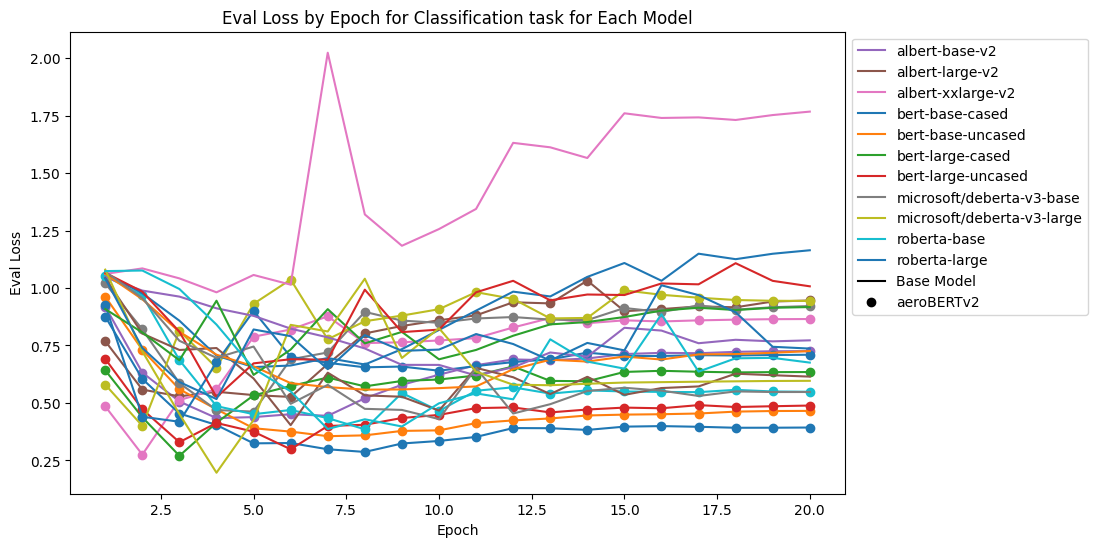

In [48]:
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# Set the plot size
plt.figure(figsize=(10, 6))

# Assuming 'all_model' contains a list of all unique model names
colors = plt.cm.tab10.colors  # Using a colormap from matplotlib for up to 10 different lines
color_map = {}  # Dictionary to map model names to colors
for i, model in enumerate([x for x in all_model if x != 'albert-xlarge-v2']):
    color_map[model] = colors[i % len(colors)]  # Cycle through colors if more than available

# Define marker style for aeroBERTv2
aeroBERTv2_marker = 'o'  # Example: 'o' for circle markers

# Initialize empty lists for legend handling
handles, labels = [], []

# Group by 'Model name' and plot
for model_name, group in df.groupby('Model name'):
    # Check if the model is aeroBERTv2 to apply a marker
    if 'albert-xlarge-v2' in model_name:
        continue
    if 'aeroBERTv2' in model_name:
        plt.plot(group['Epoch'], group['eval_loss'], marker=aeroBERTv2_marker, color=color_map[model_name.replace("aeroBERTv2-", "")], label='_nolegend_')
    else:
        line = plt.plot(group['Epoch'], group['eval_loss'], color=color_map[model_name], label=model_name)
        handles.append(line[0])  # Add the line object to the handles list
        labels.append(model_name)  # Add the model name to the labels list

# Adding plot title and labels
plt.title('Eval Loss by Epoch for Classification task for Each Model')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')

# Create custom legends
aeroBERT_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='aeroBERTv2')
base_legend = mlines.Line2D([], [], color='black', linestyle='-', label='Base Model')

# Show legend - combine auto-generated legends with custom ones
plt.legend(handles=handles + [base_legend, aeroBERT_legend], labels=labels + ['Base Model', 'aeroBERTv2'],loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()


# Figure 2. Graph of NER eval_loss per epoch

In [50]:
trainer_result = {}
for model in all_model:
    # load trainer_state.json
    trainer_state = json.load(open(f"../output/ner/{model}/trainer_state.json"))
    trainer_result[model] = [a["eval_loss"] for a in trainer_state["log_history"] if "eval_loss" in a]
    # aerobertv2
    trainer_state = json.load(open(f"../output/ner/aeroBERTv2-{model}/trainer_state.json"))
    trainer_result[f"aeroBERTv2-{model}"] = [a["eval_loss"] for a in trainer_state["log_history"] if "eval_loss" in a]
# Expanding the data
rows = []
for model_name, eval_losses in trainer_result.items():
    for epoch, loss in enumerate(eval_losses, 1):
        rows.append([model_name, epoch, loss])

# Creating the DataFrame
df = pd.DataFrame(rows, columns=['Model name', 'Epoch', 'eval_loss'])

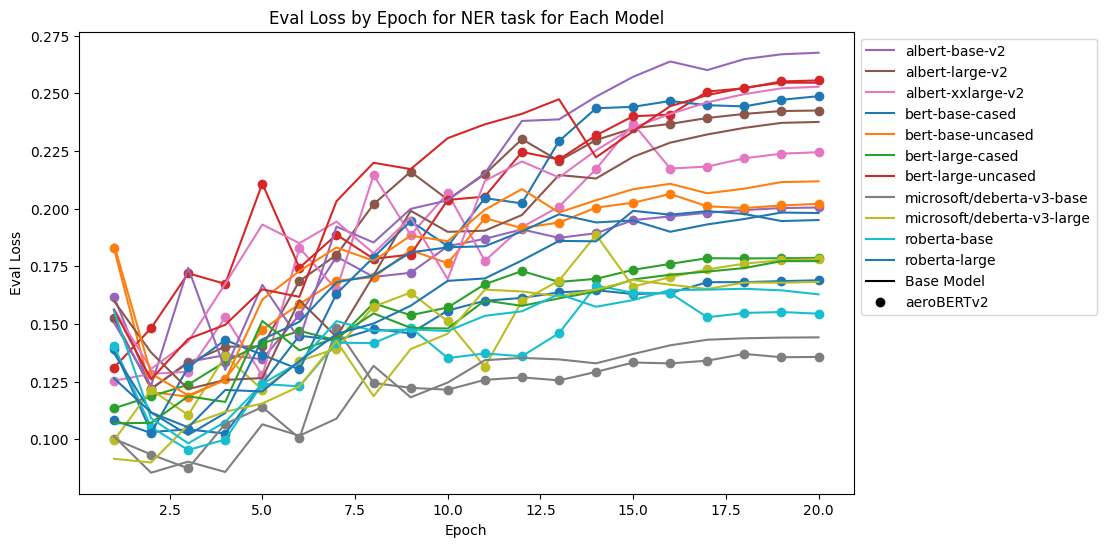

In [51]:
# Set the plot size
plt.figure(figsize=(10, 6))

# Assuming 'all_model' contains a list of all unique model names
colors = plt.cm.tab10.colors  # Using a colormap from matplotlib for up to 10 different lines
color_map = {}  # Dictionary to map model names to colors
for i, model in enumerate([x for x in all_model if x != 'albert-xlarge-v2']):
    color_map[model] = colors[i % len(colors)]  # Cycle through colors if more than available

# Define marker style for aeroBERTv2
aeroBERTv2_marker = 'o'  # Example: 'o' for circle markers

# Initialize empty lists for legend handling
handles, labels = [], []

# Group by 'Model name' and plot
for model_name, group in df.groupby('Model name'):
    # Check if the model is aeroBERTv2 to apply a marker
    if 'albert-xlarge-v2' in model_name:
        continue
    if 'aeroBERTv2' in model_name:
        plt.plot(group['Epoch'], group['eval_loss'], marker=aeroBERTv2_marker, color=color_map[model_name.replace("aeroBERTv2-", "")], label='_nolegend_')
    else:
        line = plt.plot(group['Epoch'], group['eval_loss'], color=color_map[model_name], label=model_name)
        handles.append(line[0])  # Add the line object to the handles list
        labels.append(model_name)  # Add the model name to the labels list

# Adding plot title and labels
plt.title('Eval Loss by Epoch for NER task for Each Model')
plt.xlabel('Epoch')
plt.ylabel('Eval Loss')

# Create custom legends
aeroBERT_legend = mlines.Line2D([], [], color='black', marker='o', linestyle='None', label='aeroBERTv2')
base_legend = mlines.Line2D([], [], color='black', linestyle='-', label='Base Model')

# Show legend - combine auto-generated legends with custom ones
plt.legend(handles=handles + [base_legend, aeroBERT_legend], labels=labels + ['Base Model', 'aeroBERTv2'],loc='upper left', bbox_to_anchor=(1, 1))

# Display the plot
plt.show()
